# Processamento de Linguagem Natural - Minicurso do SBBD 2022

Esse código foi desenvolvido para o minicurso de PLN no SBBD 2022.

Autoras: Helena Caseli, Cláudia Freitas e Roberta Viola

https://sites.google.com/view/brasileiras-pln/

Fontes:
* Gensim: https://radimrehurek.com/gensim/models/keyedvectors.html
* NILC embeddings: http://nilc.icmc.usp.br/embeddings

Esse código está composto de duas partes:

1. Na primeira, baixamos as *word embeddings* pré-treinadas do NILC e as utilizamos
2. Na segunda, criamos nossas próprias *word embeddings* a partir de um *corpus*



# 1. Usando *word embeddings* pré-treinadas
Algumas opções de *word embeddings* pré-treinadas para o português são:

* *Word embeddings* monolíngues (ex: NILC word embeddings disponíveis em http://nilc.icmc.usp.br/embeddings)
* *Word embeddings* multilíngues (ex: MUSE word embedings disponíveis em https://github.com/facebookresearch/MUSE)

Vamos baixar e usar as *word embeddings* do NILC treinadas com GloVe conforme informações disponíveis na página das NILC *word embeddings* (WEs) citada acima.

In [ ]:
!wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip
#http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s50.zip # Outra opção de arquivo com embeddings de dimensão menor (50)

Se tudo deu certo com a execução acima, então o arquivo "download...glove_s300.zip" estará disponível na sua área de arquivos do CoLab. Para conferir, vá na barra lateral à esquerda, clique no ícone de "pasta" e verifique que o arquivo está aí.

Em seguida, nós descompactamos o arquivo zipado das WEs e carregamos elas usando o gensim.

In [ ]:
!unzip -o download.php?file=embeddings%2Fglove%2Fglove_s300.zip

Archive:  download.php?file=embeddings%2Fglove%2Fglove_s300.zip
  inflating: glove_s300.txt          


Essas *word embeddings* serão manipuladas pela biblioteca Python gensim, bastante útil para representar textos. Na gensim encontramos implementações de algoritmos não supervisionados bastante úteis para processamento de texto como Word2Vec, FastText, LDA, entre outros.

In [ ]:
import gensim

In [ ]:
nilc_glove = gensim.models.KeyedVectors.load_word2vec_format('glove_s300.txt')

Para verificar a representação de uma palavra nas NILC *embeddings* baixadas anteriormente, basta consultar a entrada para essa palavra específica.

In [ ]:
nilc_glove['rainha']

## Verificando a similaridade entre palavras
Nessa seção vamos fazer algumas manipulações básicas com as WEs do NILC para encontrar a similaridade entre palavras.

Por exemplo, para verificar a similaridade (de cosseno, por *default*) entre duas palavras basta fazer:

In [ ]:
nilc_glove.similarity('rainha','rei')

0.6457715

Por exemplo, ao fazer 

resultado = vetor[mulher] + vetor[rei] - vetor[homem]

o vetor mais próximo do resultado é o vetor de "rainha".

In [ ]:
resultado = nilc_glove.most_similar(positive=['mulher', 'rei'], negative=['homem'])
print("{}: {:.4f}".format(*resultado[0]))

rainha: 0.7193


In [ ]:
resultado = nilc_glove.most_similar(positive=['amar', 'odiando'], negative=['odiar'])
print("{}: {:.4f}".format(*resultado[0]))

amando: 0.3852


Também podemos conferir quais são as *n* palavras mais próximas (o default do most_similar é *n* = 10) de uma determinada palavra, por exemplo: "escola".

In [ ]:
nilc_glove.most_similar("gelo")

[('neve', 0.5780766010284424),
 ('hóquei', 0.5205349326133728),
 ('patinação', 0.5061798095703125),
 ('inverno', 0.4859928786754608),
 ('areia', 0.4829706847667694),
 ('derreter', 0.46780431270599365),
 ('camada', 0.45113053917884827),
 ('gelada', 0.4471437335014343),
 ('quente', 0.4423791468143463),
 ('água', 0.44236570596694946)]

Por fim, é possível verificar qual palavra distoa em um grupo de quatro palavras, por exemplo: menina, menino, cão e garota.

In [ ]:
print(nilc_glove.doesnt_match("menina menino cão garota".split()))

cão


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## Verificando a similaridade entre sentenças

Além de verificar a similaridade entre palavas, o gensim também já tem algumas rotinas para calcular a similaridade entre sentenças. Por exemplo, a similaridade da sentença "O menino foi para a escola de ônibus." e as sentenças "Ana foi para a escola ontem." e "A menina foi para casa.". Veja que a similaridade com a última é maior do que com a primeira, isso porque as similaridades das palavras é maior.

In [ ]:
sentenca = "O menino foi para a escola de ônibus.".lower().split()

sent1 = "Ana foi para a escola ontem.".lower().split()
similaridade = nilc_glove.wmdistance(sentenca, sent1)
print("{:.4f}".format(similaridade))

sent2 = "A menina foi para casa.".lower().split()
similaridade = nilc_glove.wmdistance(sentenca, sent2)
print("{:.4f}".format(similaridade))

3.9910
4.4467


# 2. Gerando nossas próprias *word embeddings*

Agora vamos gerar WEs para um *corpus*. Veja que todas as rotinas e os cálculos apresentados na parte 1 continuam aplicáveis com as novas WEs que vamos gerar!

Para gerar nossas WEs vamos precisar de um *corpus* ...

## O *corpus*

Vamos usar um csv de um desafio do Kaggle para análise de sentimentos, em português:

* https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis

In [ ]:
!wget https://www.kaggle.com/input/portuguese-tweets-for-sentiment-analysis/NoThemeTweets.csv

In [ ]:
!unzip -o 'NoThemeTweets.csv.zip'

Archive:  NoThemeTweets.csv.zip
  inflating: NoThemeTweets.csv       


Outra bibliteca bem legal para manipular dados é a pandas. Vamos usá-la para dar uma olhada nos campos do arquivo .csv que baixamos.

In [ ]:
import pandas as pd
corpus = pd.read_csv('NoThemeTweets.csv', sep=',')
corpus.head(10)

,id,tweet_text,tweet_date,sentiment,query_used
0,1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,:)
1,1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,:)
2,1031760962372689920,Eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,:)
3,1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,:)
4,1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Tue Aug 21 04:32:21 +0000 2018,Positivo,:)
5,1031760822543020032,"@BadWolf_Wagner @DanieVedo Eu entendi, mas iss...",Tue Aug 21 04:32:03 +0000 2018,Positivo,:)
6,1031760780641718272,@Chyko661 @g1 [+] Carcinoma Hepatico (Cancer d...,Tue Aug 21 04:31:53 +0000 2018,Positivo,:)
7,1031760749813805058,"Aquela mina da limpeza, que tinha um marido co...",Tue Aug 21 04:31:46 +0000 2018,Positivo,:)
8,1031760690778976262,"@narryfools aqui, espero que você melhore logo...",Tue Aug 21 04:31:32 +0000 2018,Positivo,:)
9,1031760658600284160,@fefocaires se és feliz trabalhando nisso entã...,Tue Aug 21 04:31:24 +0000 2018,Positivo,:)


Para nós, o que vamos usar é só o campo tweet_text, pois é ele que armazenas os tweets. Por exemplo, o terceiro tweet é acessado na posição 2 (as posições começam no 0).

In [ ]:
tweets = corpus["tweet_text"].values
tweets[2]

'Eu só queria conseguir comer alguma coisa pra poder dormir :)'

##Processamento básico
Neste processamento básico vamos usar uma das ferramentas mais conhecidas para processamento automático de língua natural: o NLTK (https://www.nltk.org/).

Links interessantes:

* http://www.nltk.org/howto/portuguese_en.html
* https://www.kaggle.com/leandrodoze/examples-from-nltk-book-in-portuguese
* https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


O primeiro passo é "ler" e armazenar todas as sentenças (tweets) do nosso *corpus*, convertendo as palavras para minúsculas, removendo stopwords e *tokens* que não tenham letras nem números.


In [ ]:
sentencas = []
for tweet in tweets:
    tokens = nltk.word_tokenize(tweet)  
    processada = [w.lower() for w in tokens if not w in stopwords and w.isalnum()]    
    sentencas.append(processada)
len(sentencas)


785814

No total, nosso *corpus* possui 785.814 sentenças e após o processamento acima, a terceira sentença ficou:

In [ ]:
sentencas[2]

['eu',
 'queria',
 'conseguir',
 'comer',
 'alguma',
 'coisa',
 'pra',
 'poder',
 'dormir']

## Gerando *word embeddings*
Agora estamos prontos para gerar nossas WEs a partir dessas sentenças. Para isso basta executar o código abaixo, que gera WEs usando word2vec (um dos algoritmos mais tradicionais para geração de WEs) com dimensão 300 (a mesma das WEs do NILC).

In [ ]:
from gensim.models import Word2Vec
meu_modelo = Word2Vec(sentencas, 
                 min_count=3,   # Ignora palavras que ocorrem menos de 3 vezes
                 size=300,      # Dimensão das embeddings
                 workers=2,     # Número de processadores (paralelização)
                 window=5,      # Tamanho da janela de contexto, em palavras, usada durante o treinamento
                 iter=30)       # Número de épocas de treinamento

É possível conferir a quantidade de palavras para as quais foram geradas WEs:

In [ ]:
len(meu_modelo.wv.vocab)

83545

E dar uma olhada em quais são essas palavras:

In [ ]:
print(meu_modelo.wv.vocab.keys())

dict_keys(['14', 'ir', 'drexalvarez', 'o', 'like', 'dei', 'época', 'eu', 'queria', 'conseguir', 'comer', 'alguma', 'coisa', 'pra', 'poder', 'dormir', 'd', 'lindo', 'dia', 'pq', 'pr', 'jeito', 'oferta', 'ha', 'q', 'aproveitar', 'p', 'danievedo', 'entendi', 'porque', 'pensei', 'outra', 'g1', 'cancer', 'figado', 'deivison', 'lutou', 'contra', 'doença', 'ano', 'faleceu', 'ontem', 'tarde', 'espero', 'explicaçao', 'ajudado', 'aquela', 'mina', 'limpeza', 'marido', 'problema', 'adicionou', 'aqui', 'face', 'esquisito', 'princípio', 'ah', 'nega', 'velha', 'pa', 'veio', 'perguntar', 'tô', 'ela', 'deve', 'ter', 'tomado', 'dor', 'viu', 'malzao', 'pá', 'narryfools', 'melhore', 'logo', 'https', 'fefocaires', 'és', 'feliz', 'trabalhando', 'nisso', 'então', 'pare', 'pessoas', 'incomodam', 'opinião', 'dão', 'ouvido', 'trabalho', 'grande', 'alcance', 'vamos', 'seguir', 'insta', 'quiser', 'sdv', 'tercadetremurasdv', 'thegr8angelica', 'vc', 'mt', 'obg', 'sinto', 'melhor', 'agr', 'foo', 'quando', 'joga', 'y

Nessas novas WEs, as palavras mais similares à "escola" são:

In [ ]:
meu_modelo.most_similar("escola")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('faculdade', 0.6026803255081177),
 ('facul', 0.5070286989212036),
 ('aula', 0.5039716958999634),
 ('sala', 0.4812603294849396),
 ('colégio', 0.4746965765953064),
 ('escolinha', 0.47399982810020447),
 ('academia', 0.4638780355453491),
 ('casa', 0.4574583172798157),
 ('uni', 0.43480294942855835),
 ('universidade', 0.4268164336681366)]

É interessante notar que o contexto mais usual do Twitter faz com que seja possível encontrar gíras como "facul" e "uni" como palavras similares a "escola".

## Salvando as *word embeddings* geradas

Por fim, podemos salvar (e é importante que você faça isso, pois o CoLab vai sumir com tudo assim que essa seção terminar) o modelo treinado para ser carregado para uso futuro (de modo similar ao que fizemos na parte 1 desse código).

In [ ]:
meu_modelo.wv.save_word2vec_format('meu_modelo.bin', binary=True)

## Visualizando as *word embeddings*
Uma das coisas mais legais para se fazer com as WEs é plotá-las em duas dimensões para analisar visualmente a distância entre as palavras. É isso o que faremos a seguir.

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('classic')
from sklearn.decomposition import PCA

In [ ]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    

In [ ]:
meu_modelo.most_similar('escola')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('faculdade', 0.6026803255081177),
 ('facul', 0.5070286989212036),
 ('aula', 0.5039716958999634),
 ('sala', 0.4812603294849396),
 ('colégio', 0.4746965765953064),
 ('escolinha', 0.47399982810020447),
 ('academia', 0.4638780355453491),
 ('casa', 0.4574583172798157),
 ('uni', 0.43480294942855835),
 ('universidade', 0.4268164336681366)]

Plotando o vetor da palavra "escola" e as 10 palavras mais próximas a ele, de acordo com o modelo que acabamos de treinar.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


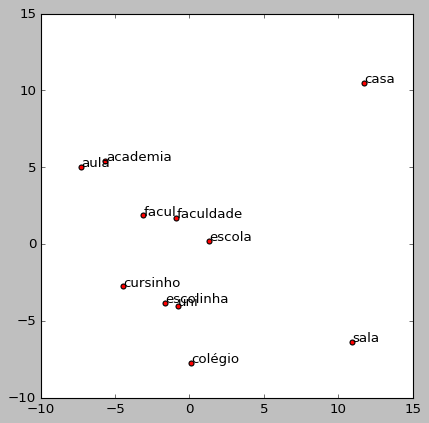

In [ ]:
words = ['escola', 'faculdade', 'facul', 'aula', 'sala', 'colégio', 'academia', 'casa', 'escolinha', 'uni', 'cursinho']
display_pca_scatterplot(meu_modelo,words)

Plotando o vetor da palavra "escola" e as 10 palavras mais próximas a ele, de acordo com o modelo do NILC.

In [ ]:
nilc_glove.most_similar('escola')

[('alunos', 0.6777069568634033),
 ('escolas', 0.6750764846801758),
 ('ensino', 0.6746147871017456),
 ('colégio', 0.673301100730896),
 ('faculdade', 0.6269355416297913),
 ('aula', 0.6062946319580078),
 ('aulas', 0.6045212745666504),
 ('educação', 0.6030406355857849),
 ('professores', 0.5954739451408386),
 ('escolar', 0.5880724191665649)]

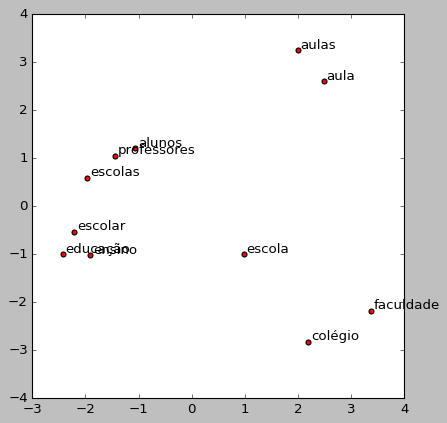

In [ ]:
words = ['escola', 'alunos', 'escolas', 'ensino', 'colégio', 'faculdade', 'aula', 'aulas', 'educação', 'professores', 'escolar']
display_pca_scatterplot(nilc_glove,words)

Fim deste código.